# Collaboration and Competition

---

In this notebook, you will see how to train the Tennis Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

### 4. Train the Agent

In [6]:
import os
import argparse
import random
import torch
import matplotlib.pyplot as plt
from collections import deque
from agent import Agent

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=10)

In [8]:
def ddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    average_scores = []                 
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action1 = agent.act(state[0])
            action2 = agent.act(state[1])
            action = np.concatenate((action1, action2), axis=0)
            action = np.clip(action, -1, 1)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if np.any(done):
                break
        scores_deque.append(np.max(score))
        scores.append(np.max(score))
        average_scores.append(np.mean(scores_deque))  
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) > 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode-100,np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores, average_scores

In [9]:
scores, average_scores = ddpg(n_episodes=10000, max_t=1000)

Episode 100	Average Score: 0.0000
Episode 200	Average Score: 0.0009
Episode 300	Average Score: 0.0029
Episode 400	Average Score: 0.0000
Episode 500	Average Score: 0.0115
Episode 600	Average Score: 0.0321
Episode 700	Average Score: 0.0306
Episode 800	Average Score: 0.0322
Episode 900	Average Score: 0.0288
Episode 1000	Average Score: 0.0542
Episode 1100	Average Score: 0.0840
Episode 1200	Average Score: 0.0872
Episode 1300	Average Score: 0.0961
Episode 1400	Average Score: 0.1200
Episode 1500	Average Score: 0.4402
Episode 1519	Average Score: 0.5033
Environment solved in 1419 episodes!	Average Score: 0.5033


### 5. Plot the scores

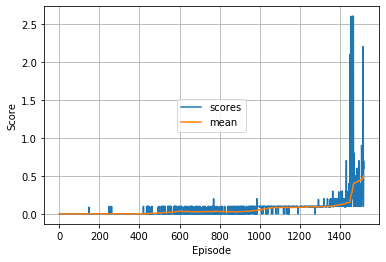

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='scores')
plt.plot(np.arange(1, len(average_scores)+1), average_scores, label='mean')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend(loc='center')
plt.grid()
plt.show()

### 6. Watch a smart Agent!

In [11]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
env_info = env.reset(train_mode=False)[brain_name]     
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          
while True:
    action1 = agent.act(states[0])
    action2 = agent.act(states[1])
    actions = np.concatenate((action1, action2), axis=0)
    actions = np.clip(actions, -1, 1)                 
    env_info = env.step(actions)[brain_name]          
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                         
    dones = env_info.local_done                       
    scores += env_info.rewards                         
    states = next_states                              
    if np.any(dones):                                 
        break
print('Score (max over agents): {}'.format(np.max(scores)))

Score (max over agents): 0.10000000149011612


### 7. Close the environment

In [12]:
env.close()